Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./notMNIST_large already present - Skipping extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [5]:
def random_displays(train_folders):
  for folder_name in train_folders:
    display(Image(filename="%s/%s" % (folder_name, np.random.choice(os.listdir(folder_name)))))


# random_displays(train_folders)

In [6]:
image_size = 28 # Number of pixels in a row/column.
pixel_depth = 255.0 # Number of levels in a pixel of the image.

def load_letter(folder, min_num_images):
  """
  Load all images in a single letter's folder.
  """
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size), dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - pixel_depth/2) / pixel_depth
      if  image_data.shape != (image_size, image_size):
          raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images += 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset


def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pkl'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

./notMNIST_large/A.pkl already present - Skipping pickling.
./notMNIST_large/B.pkl already present - Skipping pickling.
./notMNIST_large/C.pkl already present - Skipping pickling.
./notMNIST_large/D.pkl already present - Skipping pickling.
./notMNIST_large/E.pkl already present - Skipping pickling.
./notMNIST_large/F.pkl already present - Skipping pickling.
./notMNIST_large/G.pkl already present - Skipping pickling.
./notMNIST_large/H.pkl already present - Skipping pickling.
./notMNIST_large/I.pkl already present - Skipping pickling.
./notMNIST_large/J.pkl already present - Skipping pickling.
./notMNIST_small/A.pkl already present - Skipping pickling.
./notMNIST_small/B.pkl already present - Skipping pickling.
./notMNIST_small/C.pkl already present - Skipping pickling.
./notMNIST_small/D.pkl already present - Skipping pickling.
./notMNIST_small/E.pkl already present - Skipping pickling.
./notMNIST_small/F.pkl already present - Skipping pickling.
./notMNIST_small/G.pkl already present -

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

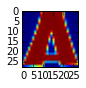

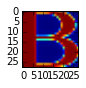

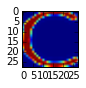

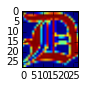

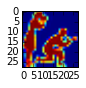

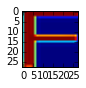

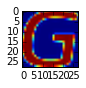

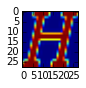

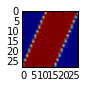

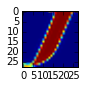

In [7]:
def verify_pickled_data(datasets):
  for dataset_name in datasets:
    with open(dataset_name) as f:
      dataset = pickle.load(f)
      random_image = dataset[np.random.choice(dataset.shape[0]), :, :]
      plt.figure(figsize = (1,1))
      plt.imshow(random_image)

      
verify_pickled_data(train_datasets)

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [8]:
def verify_data_points(datasets):
  for dataset_name in datasets:
    with open(dataset_name) as f:
      dataset = pickle.load(f)
      print("Images in %s = %d" % (dataset_name, dataset.shape[0]))

print("# Training")
verify_data_points(train_datasets)

print("\n# Testing")
verify_data_points(test_datasets)

# Training
Images in ./notMNIST_large/A.pkl = 52909
Images in ./notMNIST_large/B.pkl = 52911
Images in ./notMNIST_large/C.pkl = 52912
Images in ./notMNIST_large/D.pkl = 52911
Images in ./notMNIST_large/E.pkl = 52912
Images in ./notMNIST_large/F.pkl = 52912
Images in ./notMNIST_large/G.pkl = 52912
Images in ./notMNIST_large/H.pkl = 52912
Images in ./notMNIST_large/I.pkl = 52912
Images in ./notMNIST_large/J.pkl = 52911

# Testing
Images in ./notMNIST_small/A.pkl = 1872
Images in ./notMNIST_small/B.pkl = 1873
Images in ./notMNIST_small/C.pkl = 1873
Images in ./notMNIST_small/D.pkl = 1873
Images in ./notMNIST_small/E.pkl = 1873
Images in ./notMNIST_small/F.pkl = 1872
Images in ./notMNIST_small/G.pkl = 1872
Images in ./notMNIST_small/H.pkl = 1872
Images in ./notMNIST_small/I.pkl = 1872
Images in ./notMNIST_small/J.pkl = 1872


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [9]:
def make_empty_arrays(nb_rows, img_size):
  dataset, labels = None, None
  if nb_rows:
    dataset = np.ndarray(shape=(nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(shape=nb_rows, dtype=np.float32)
  return dataset, labels


def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_empty_arrays(valid_size, image_size)
  train_dataset, train_labels = make_empty_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class + tsize_per_class
  for label, pickle_file in enumerate(pickle_files):
    try:
      with open(pickle_file) as f:
        letter_set = pickle.load(f)
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_dataset[start_v:end_v, :, :] = letter_set[:vsize_per_class, :, :]
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
        train_dataset[start_t:end_t, :, :] = letter_set[vsize_per_class:end_l, :, :]
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
  return valid_dataset, valid_labels, train_dataset, train_labels


# train_size = 200000
# valid_size = 10000
# test_size = 10000
#
# valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(train_datasets, train_size, valid_size)
# _, __, test_dataset, test_labels = merge_datasets(test_datasets, test_size)
#
# print('Training:', train_dataset.shape, train_labels.shape)
# print('Validation:', valid_dataset.shape, valid_labels.shape)
# print('Testing:', test_dataset.shape, test_labels.shape)

Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [10]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
# train_dataset, train_labels = randomize(train_dataset, train_labels)
# test_dataset, test_labels = randomize(test_dataset, test_labels)
# valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

In [11]:
"""
---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---
"""

def verify_shuffled(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])[:3]
  for p in permutation:
    plt.figure(figsize = (1,1))
    plt.imshow(dataset[p])
    plt.title(string.uppercase[int(labels[p])])

# print('# Training')
# verify_shuffled(train_dataset, train_labels)
# print('# Test')
# verify_shuffled(test_dataset, test_labels)
# print('# Validation')
# verify_shuffled(valid_dataset, valid_labels)

Finally, let's save the data for later reuse:

In [13]:
pickle_file = os.path.join(data_root, 'notMNIST.pkl')


def load_data():
  try:
    with open(pickle_file) as f:
      load = pickle.load(f)
  except Exception as e:
    print('Unable to load data from', pickle_file, ':', e)
    raise
  return load

load = load_data()
train_dataset = load['train_dataset']
train_labels = load['train_labels']
valid_dataset = load['valid_dataset']
valid_labels = load['valid_labels']
test_dataset = load['test_dataset']
test_labels = load['test_labels']


def save_data(file_name, train_x, train_y, valid_x, valid_y, test_x, test_y):
  try:
    f = open(file_name, 'wb')
    save = {
        'train_dataset': train_x,
        'train_labels': train_y,
        'valid_dataset': valid_x,
        'valid_labels': valid_y,
        'test_dataset': test_x,
        'test_labels': test_y,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
  except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise
# save_data()

In [14]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800406


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [15]:
def remove_self_duplicates(src, labels):
  src_hashed = np.array([hashlib.sha256(img).hexdigest() for img in src])
  cleaned_src, cleaned_labels = [], []
  for i, hash_i in enumerate(src_hashed):
    duplicates = np.where(src_hashed[i+1:] == hash_i)
    if len(duplicates[0]) == 0:
      cleaned_src.append(src[i])
      cleaned_labels.append(labels[i])
  return np.array(cleaned_src), np.array(cleaned_labels)


def remove_duplicates(src, dst, src_labels):
  src_hashed = np.array([hashlib.sha256(img).hexdigest() for img in src])
  dst_hashed = np.array([hashlib.sha256(img).hexdigest() for img in dst])
  duplicate_ids = []
  for i, hash_i in enumerate(src_hashed):
    duplicates = np.where(dst_hashed == hash_i)
    if len(duplicates[0]):
      duplicate_ids.append(i)
  return np.delete(src, duplicate_ids, 0), np.delete(src_labels, duplicate_ids)

# print(len(test_dataset), len(train_dataset))
# cleaned_train_dataset, cleaned_train_labels = remove_self_duplicates(train_dataset, train_labels)
# print(np.shape(cleaned_train_dataset), np.shape(train_dataset))
# cleaned_test_dataset, cleaned_test_labels = remove_duplicates(test_dataset, cleaned_train_dataset, test_labels)
# print(np.shape(cleaned_test_dataset), np.shape(test_dataset))
# cleaned_valid_dataset, cleaned_valid_labels = remove_duplicates(valid_dataset, cleaned_train_dataset, valid_labels)
# print(np.shape(cleaned_valid_dataset), np.shape(valid_labels))

cleaned_pickle_file = os.path.join(data_root, 'cleaned_notMNIST.pkl')
# save_data(cleaned_pickle_file, cleaned_train_dataset, cleaned_train_labels, cleaned_valid_dataset,
#           cleaned_valid_labels, cleaned_test_dataset, cleaned_test_labels)

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to
check that there is something to learn, and that it's a problem that is not so trivial that a canned
solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use
the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [16]:
def train_and_predict(size):
  # Train
  model = LogisticRegression()
  x_train = train_dataset[:size].reshape(size, image_size * image_size) # Convert 2d image into 1d for training
  y_train = train_labels[:size]
  model.fit(x_train, y_train)
  # Predict
  x_test = test_dataset.reshape(test_dataset.shape[0], image_size * image_size)
  print("Sample Size: ", size, "; Accuracy: ", model.score(x_test, test_labels))


def train_for_samples(samples):
  for sample in samples:
    train_and_predict(sample)

train_for_samples([50, 100, 1000, 5000, len(train_dataset)])

Sample Size:  50 ; Accuracy:  0.509
Sample Size:  100 ; Accuracy:  0.6966
Sample Size:  1000 ; Accuracy:  0.8333
Sample Size:  5000 ; Accuracy:  0.8511
